## Development notebook  FCN model 

Evaluate returned heatmap values from FCN, by passing data through MRCNN and then through FCN

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, math, io, time, gc, argparse, platform, pprint
import numpy as np
import tensorflow as tf
import keras
import keras.backend as KB
sys.path.append('../')
import mrcnn.model_mrcnn  as mrcnn_modellib
import mrcnn.model_fcn    as fcn_modellib
import mrcnn.visualize    as visualize
import mrcnn.new_shapes   as shapes
import mrcnn.utils        as utils

from datetime           import datetime   
from mrcnn.utils        import command_line_parser, Paths
from mrcnn.config       import Config
from mrcnn.dataset      import Dataset 

# from mrcnn.utils        import log, stack_tensors, stack_tensors_3d, write_stdout
# from mrcnn.datagen      import data_generator, load_image_gt, data_gen_simulate
from mrcnn.datagen_fcn  import fcn_data_gen_simulate
from mrcnn.callbacks    import get_layer_output_1,get_layer_output_2
# from mrcnn.coco         import CocoDataset, CocoInferenceConfig, evaluate_coco, build_coco_results
from mrcnn.coco         import CocoConfig
# from mrcnn.heatmap      import HeatmapDataset
from mrcnn.prep_notebook import prep_heatmap_dataset

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
start_time = datetime.now().strftime("%m-%d-%Y @ %H:%M:%S")
print()
print('--> Execution started at:', start_time)
print("    Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))

####  Pass input parameters to argparse

# args = parser.parse_args("--epochs 100 --steps_in_epoch 128  --last_epoch 1264 --batch_size 8  --lr 0.5               --logs_dir train_fcn_adagrad --model /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 --fcn_model init".split())
# input_parms = "--epochs 100 --steps_in_epoch 100  --last_epoch 1264 --batch_size 25 --lr 0.8 --val_steps 5 --logs_dir train_fcn_adagrad --model /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 --fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
# input_parms +=" --model     /home/kbardool/models/train_mrcnn/shapes20180621T1554/mask_rcnn_shapes_1119.h5 "
##------------------------------------------------------------------------------------
## Parse command line arguments
##------------------------------------------------------------------------------------
parser = command_line_parser()
input_parms = "--epochs 2 --steps_in_epoch 32  --last_epoch 0 --batch_size 2 --lr 0.00001 --val_steps 8 " 
# input_parms +="--mrcnn_logs_dir train_mrcnn_newshapes "
# input_parms +="--fcn_logs_dir   train_fcn8_newshapes "
input_parms +="--mrcnn_logs_dir train_mrcnn_coco "
input_parms +="--fcn_logs_dir   train_fcn8_coco "
input_parms +="--mrcnn_model    last "
input_parms +="--fcn_model      init "
input_parms +="--opt            adagrad "
input_parms +="--fcn_arch       fcn8 " 
input_parms +="--fcn_layers     all " 
input_parms +="--sysout        screen "
input_parms +="--new_log_folder    "
# input_parms +="--fcn_model /home/kbardool/models/train_fcn_adagrad/shapes20180709T1732/fcn_shapes_1167.h5"
print(input_parms)

args = parser.parse_args(input_parms.split())
# args = parser.parse_args()

##----------------------------------------------------------------------------------------------
## if debug is true set stdout destination to stringIO
##----------------------------------------------------------------------------------------------            
# debug = False
if args.sysout == 'FILE':
    sys.stdout = io.StringIO()

# print("    Dataset            : ", args.dataset)
# print("    Logs               : ", args.logs)
# print("    Limit              : ", args.limit)
print("    MRCNN Model        : ", args.mrcnn_model)
print("    FCN Model          : ", args.fcn_model)
print("    MRCNN Log Dir      : ", args.mrcnn_logs_dir)
print("    FCN Log Dir        : ", args.fcn_logs_dir)
print("    FCN Arch           : ", args.fcn_arch)
print("    FCN Log Dir        : ", args.fcn_layers)
print("    Last Epoch         : ", args.last_epoch)
print("    Epochs to run      : ", args.epochs)
print("    Steps in each epoch: ", args.steps_in_epoch)
print("    Validation steps   : ", args.val_steps)
print("    Batch Size         : ", args.batch_size)
print("    Optimizer          : ", args.opt)
print("    sysout             : ", args.sysout)
# print("    OS Platform        : ", syst)

##------------------------------------------------------------------------------------
## setup project directories
##   ROOT_DIR         : Root directory of the project 
##   MODEL_DIR        : Directory to save logs and trained model
##   COCO_MODEL_PATH  : Path to COCO trained weights
##---------------------------------------------------------------------------------
paths = Paths(fcn_training_folder = args.fcn_logs_dir, mrcnn_training_folder = args.mrcnn_logs_dir)
paths.display()

### Build Configuration Object

##------------------------------------------------------------------------------------
## Build configuration object 
##------------------------------------------------------------------------------------                          
# mrcnn_config                    = CocoConfig()
# # import mrcnn.new_shapes as new_shapes
# # mrcnn_config = new_shapes.NewShapesConfig()

# mrcnn_config.NAME               = 'mrcnn'              
# mrcnn_config.TRAINING_PATH      = paths.MRCNN_TRAINING_PATH
# mrcnn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
# mrcnn_config.COCO_MODEL_PATH    = paths.COCO_MODEL_PATH   
# mrcnn_config.RESNET_MODEL_PATH  = paths.RESNET_MODEL_PATH 
# mrcnn_config.VGG16_MODEL_PATH   = paths.VGG16_MODEL_PATH  
# mrcnn_config.COCO_CLASSES       = None 
# mrcnn_config.DETECTION_PER_CLASS = 200
# mrcnn_config.HEATMAP_SCALE_FACTOR = 4
# mrcnn_config.BATCH_SIZE         = int(args.batch_size)                  # Batch size is 2 (# GPUs * images/GPU).
# mrcnn_config.IMAGES_PER_GPU     = int(args.batch_size)                  # Must match BATCH_SIZE

# mrcnn_config.STEPS_PER_EPOCH    = int(args.steps_in_epoch)
# mrcnn_config.LEARNING_RATE      = float(args.lr)
# mrcnn_config.EPOCHS_TO_RUN      = int(args.epochs)
# mrcnn_config.FCN_INPUT_SHAPE    = mrcnn_config.IMAGE_SHAPE[0:2]
# mrcnn_config.LAST_EPOCH_RAN     = int(args.last_epoch)

# mrcnn_config.WEIGHT_DECAY       = 2.0e-4
# mrcnn_config.VALIDATION_STEPS   = int(args.val_steps)
# mrcnn_config.REDUCE_LR_FACTOR   = 0.5
# mrcnn_config.REDUCE_LR_COOLDOWN = 30
# mrcnn_config.REDUCE_LR_PATIENCE = 40
# mrcnn_config.EARLY_STOP_PATIENCE= 80
# mrcnn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
# mrcnn_config.MIN_LR             = 1.0e-10
# mrcnn_config.OPTIMIZER          = args.opt.upper()
# mrcnn_config.NEW_LOG_FOLDER       = True
# mrcnn_config.SYSOUT               = args.sysout
# mrcnn_config.display() 


###  Build Model

# from mrcnn.prep_notebook import mrcnn_coco_train
# mrcnn_model, mrcnn_config = mrcnn_coco_train(mode = 'training', mrcnn_config = mrcnn_config)

Using TensorFlow backend.



--> Execution started at: 11-08-2018 @ 20:30:23
    Tensorflow Version: 1.8.0   Keras Version : 2.1.6 
--epochs 2 --steps_in_epoch 32  --last_epoch 0 --batch_size 2 --lr 0.00001 --val_steps 8 --mrcnn_logs_dir train_mrcnn_coco --fcn_logs_dir   train_fcn8_coco --mrcnn_model    last --fcn_model      init --opt            adagrad --fcn_arch       fcn8 --fcn_layers     all --sysout        screen --new_log_folder    
    MRCNN Model        :  last
    FCN Model          :  init
    MRCNN Log Dir      :  train_mrcnn_coco
    FCN Log Dir        :  train_fcn8_coco
    FCN Arch           :  FCN8
    FCN Log Dir        :  ['all']
    Last Epoch         :  0
    Epochs to run      :  2
    Steps in each epoch:  32
    Validation steps   :  8
    Batch Size         :  2
    Optimizer          :  ADAGRAD
    sysout             :  SCREEN
>>> Initialize Paths
 Linx  Linux

Paths:
-------------------------
COCO_DATASET_PATH              /users/students/r0653928/MLDatasets/coco2014
COCO_HEATMAP_PATH   

##  Build FCN Model 

In [2]:
from mrcnn.utils import Paths
paths = Paths(fcn_training_folder='train_fcn8_coco_datagen')
paths.display()
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.COCO_DATASET_PATH  = paths.COCO_DATASET_PATH 
fcn_config.COCO_HEATMAP_PATH  = paths.COCO_HEATMAP_PATH 

# mrcnn_config.COCO_MODEL_PATH    = COCO_MODEL_PATH   
# mrcnn_config.RESNET_MODEL_PATH  = RESNET_MODEL_PATH 
fcn_config.NAME                 = 'fcn'              
fcn_config.TRAINING_PATH        = paths.FCN_TRAINING_PATH
fcn_config.VGG16_MODEL_PATH     = paths.FCN_VGG16_MODEL_PATH
fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.IMAGE_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 

fcn_config.BATCH_SIZE           = int(args.batch_size)                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = int(args.batch_size)                   # Must match BATCH_SIZE
fcn_config.EPOCHS_TO_RUN        = int(args.epochs)
fcn_config.STEPS_PER_EPOCH      = int(args.steps_in_epoch)
fcn_config.LAST_EPOCH_RAN       = int(args.last_epoch)

fcn_config.LEARNING_RATE        = float(args.lr)

fcn_config.VALIDATION_STEPS     = int(args.val_steps)
fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4

fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 5
fcn_config.REDUCE_LR_PATIENCE   = 5
fcn_config.EARLY_STOP_PATIENCE  = 15
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
 
fcn_config.NEW_LOG_FOLDER       = args.new_log_folder
fcn_config.OPTIMIZER            = args.opt
fcn_config.SYSOUT               = args.sysout

fcn_config.display()

#### Build Model

##------------------------------------------------------------------------------------
## Build FCN Model in Training Mode
##------------------------------------------------------------------------------------
try :
    del fcn_model
    gc.collect()
except: 
    pass    
fcn_model = fcn_modellib.FCN(mode="training", arch = 'FCN8', config=fcn_config)

####  Display FCN model info

# fcn_model.config.display()  
fcn_model.layer_info()

>>> Initialize Paths
 Linx  Linux

Paths:
-------------------------
COCO_DATASET_PATH              /users/students/r0653928/MLDatasets/coco2014
COCO_HEATMAP_PATH              /users/students/r0653928/MLDatasets/coco2014_heatmaps
COCO_MODEL_PATH                /users/students/r0653928/PretrainedModels/mask_rcnn_coco.h5
DIR_DATASET                    /users/students/r0653928/MLDatasets
DIR_PRETRAINED                 /users/students/r0653928/PretrainedModels
DIR_ROOT                       /esat/tiger/joramas/mscStudentsData/kbardool/projs/mrcnn3/notebooks
DIR_TRAINING                   /users/students/r0653928/models
FCN_TRAINING_PATH              /users/students/r0653928/models/train_fcn8_coco_datagen
FCN_VGG16_MODEL_PATH           /users/students/r0653928/PretrainedModels/fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5
MRCNN_TRAINING_PATH            /users/students/r0653928/models/train_mrcnn_coco
RESNET_MODEL_PATH              /users/students/r0653928/PretrainedModels/resnet50_weights_

## Build Training & Validation Datasets

In [3]:
dataset_train, train_generator= prep_heatmap_dataset(['train','val35k'], fcn_config, generator = True,shuffle = False)
# dataset_val, val_generator    = prep_heatmap_dataset(['minival'], fcn_config, generator = True, shuffle = False)

image_dir :  /users/students/r0653928/MLDatasets/coco2014/train2014 
 heatmap_dir:  /users/students/r0653928/MLDatasets/coco2014_heatmaps/train2014
subset:  train json_path_dir:  annotations/instances_train2014.json
loading annotations into memory...
Done (t=20.87s)
creating index...
index created!
 image dir        :  /users/students/r0653928/MLDatasets/coco2014/train2014
 json_path_dir    :  /users/students/r0653928/MLDatasets/coco2014/annotations/instances_train2014.json
 number of images :  82081
 ImageIds[:10]    :  [262145, 262146, 524291, 131074, 393221, 131075, 393223, 393224, 524297, 9]
0 0
 Images ids : 82081
    Corresponding heatmap found     : 5000
    Corresponding heatmap not found : 77081
 Total      : 82081
image_dir :  /users/students/r0653928/MLDatasets/coco2014/val2014 
 heatmap_dir:  /users/students/r0653928/MLDatasets/coco2014_heatmaps/val2014
subset:  val35k json_path_dir:  annotations/instances_valminusminival2014.json
loading annotations into memory...
Done (t=

In [6]:
dataset_train.image_ids[:20]
# for i in dataset_train.image_ids[:100]:
#     print(i, ' coco id ', dataset_train.image_info[i]['id'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [5]:
train_batch_x, train_batch_y, train_images = next(train_generator)
for i in train_batch_x:
    print(i.shape)
print(train_batch_x[0])    
print(train_images.shape)

 FCN DATAGEN starting image_index   -1 len of image ids : 5000
Image index:  0 image_id:  0
 load_heatmap_npz() :  Load Image id:  0  image_id in image_meta[]:  30000  coco_id 567245
     coco path:  /users/students/r0653928/MLDatasets/coco2014/train2014/COCO_train2014_000000567245.jpg
  heatmap path:  /users/students/r0653928/MLDatasets/coco2014_heatmaps/train2014/hm_000000567245.npz
  image_meta[0] chaged from : 30000  to :  0
 Image shape        :  (480, 640, 3) uint8 0 255
Image index:  1 image_id:  1
 load_heatmap_npz() :  Load Image id:  1  image_id in image_meta[]:  30001  coco_id 436182
     coco path:  /users/students/r0653928/MLDatasets/coco2014/train2014/COCO_train2014_000000436182.jpg
  heatmap path:  /users/students/r0653928/MLDatasets/coco2014_heatmaps/train2014/hm_000000436182.npz
  image_meta[0] chaged from : 30001  to :  1
 Image shape        :  (480, 640, 3) uint8 0 255
(2, 89)
(2, 256, 256, 81)
(2, 81, 200, 11)
(2, 256, 256, 81)
(2, 81, 200, 11)
[[   0  480  640    3

## Display Images

###  Display image with Ground Truth bounding boxes and masks

 batch size is : 2
 load image id:  40
 Image index:  [40, 243] image_id:  40
 load_heatmap_npz() :  Load Image id:  40  image_id in image_meta[]:  30040  coco_id 43029
     coco path:  /users/students/r0653928/MLDatasets/coco2014/train2014/COCO_train2014_000000043029.jpg
  heatmap path:  /users/students/r0653928/MLDatasets/coco2014_heatmaps/train2014/hm_000000043029.npz
  image_meta[0] chaged from : 30040  to :  40
 Image shape        :  (536, 640, 3) uint8 0 255
 load image id:  243
 Image index:  [40, 243] image_id:  243
 load_heatmap_npz() :  Load Image id:  243  image_id in image_meta[]:  30243  coco_id 174399
     coco path:  /users/students/r0653928/MLDatasets/coco2014/train2014/COCO_train2014_000000174399.jpg
  heatmap path:  /users/students/r0653928/MLDatasets/coco2014_heatmaps/train2014/hm_000000174399.npz
  image_meta[0] chaged from : 30243  to :  243
 Image shape        :  (420, 500, 3) uint8 0 255
 Batch size met
(2, 89)
(2, 256, 256, 81)
(2, 81, 200, 11)
(2, 256, 256, 81)

/users/students/r0653928/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/users/students/r0653928/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Class Names :  ['dining table', 'person', 'person', 'person', 'cake', 'person', 'bottle', 'bottle', 'person', 'person', 'person']


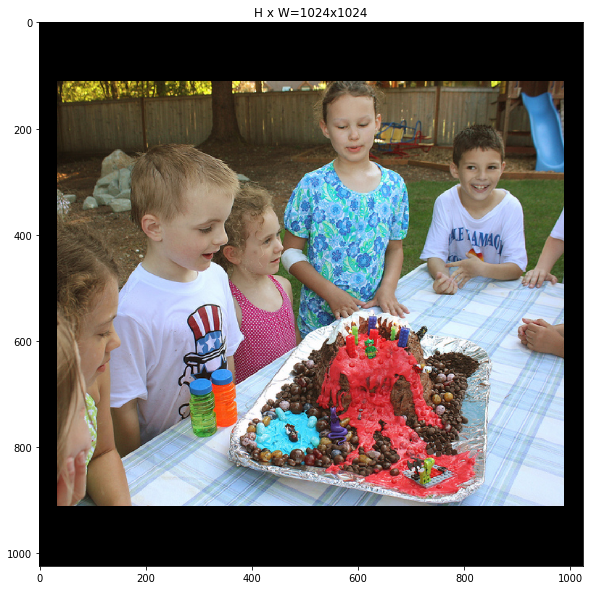

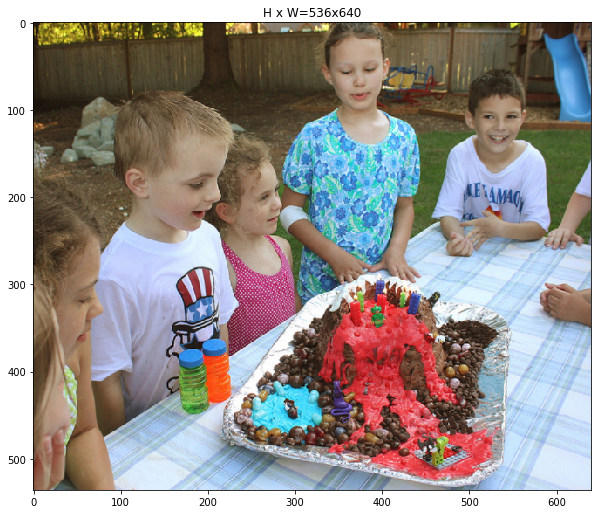

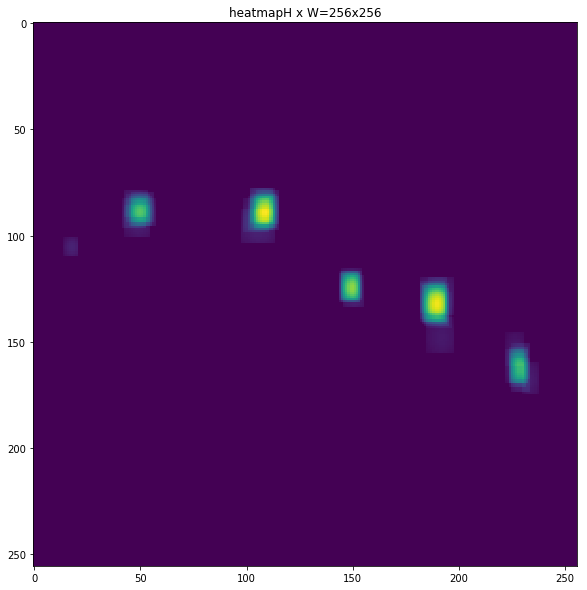

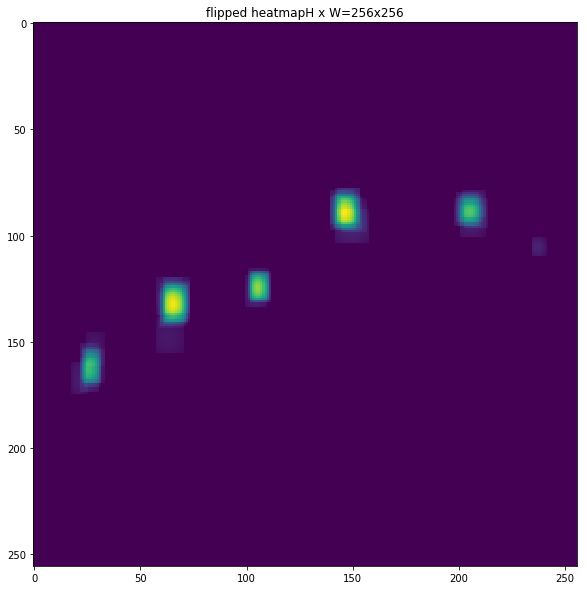

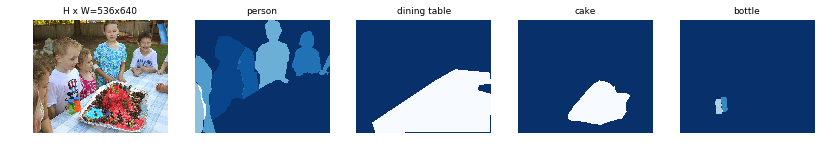

Image meta  :  [243 420 500   3 112  36 912 988   1   1]
Classes     :  [26 26 26 26  1  1  1  1  1  1  1  1  1 42 42 57  1 27 27 27 57 42 57]
image_id    :  243  Reference:  http://cocodataset.org/#explore?id=174399
 class_ids.shape[0]: 23 bbox.shape[0]: 23
unresize_image(): Resize Image from: h/w: 1024/1024  To:  h/w: 420/500  , Padding: top: 112  bot: 912  left: 36   right: 988 
unresize_image(): shape before padding removal: (1024, 1024, 3)  datatype uint8 
unresize_image(): shape after padding removal: (800, 952, 3)  datatype uint8 
unresize_image(): image shape after skimage.transform.resize: (420, 500, 3)  dtpye: uint8 
Class Names :  ['umbrella', 'umbrella', 'umbrella', 'umbrella', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'cup', 'cup', 'chair', 'person', 'handbag', 'handbag', 'handbag', 'chair', 'cup', 'chair']


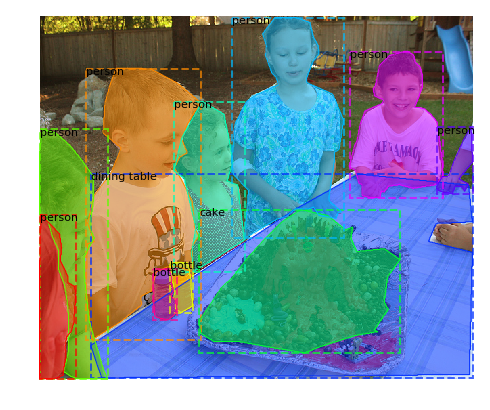

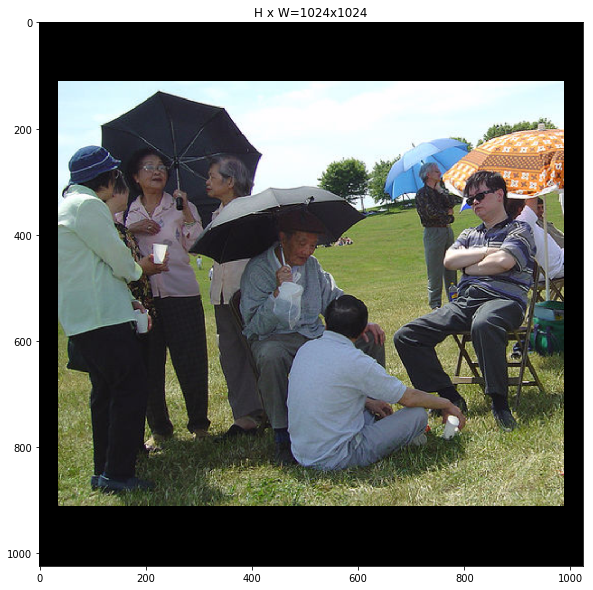

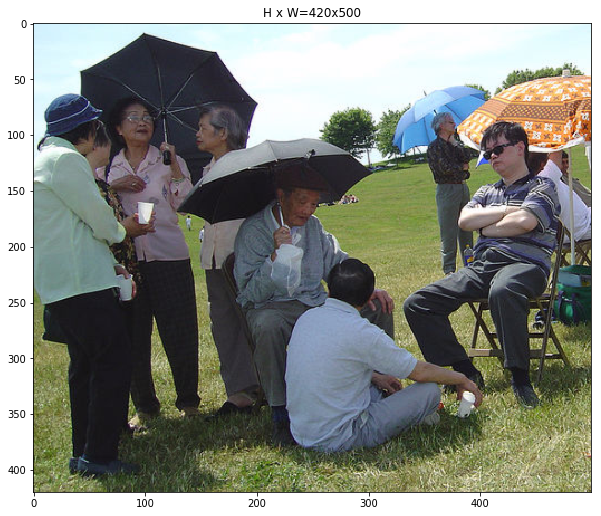

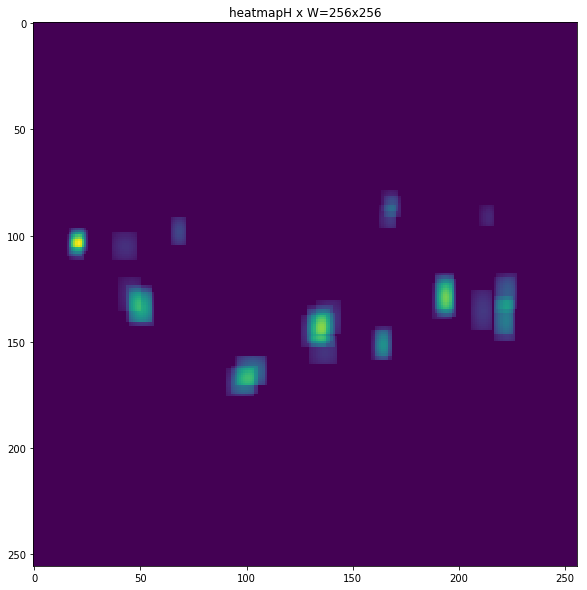

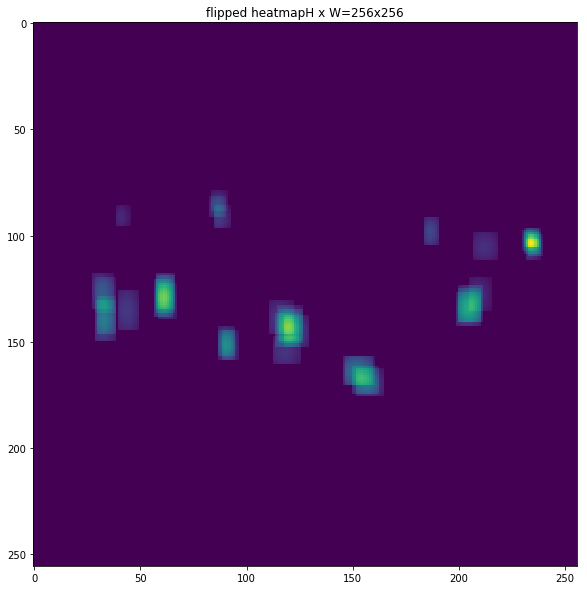

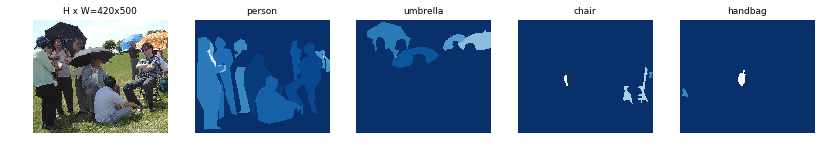

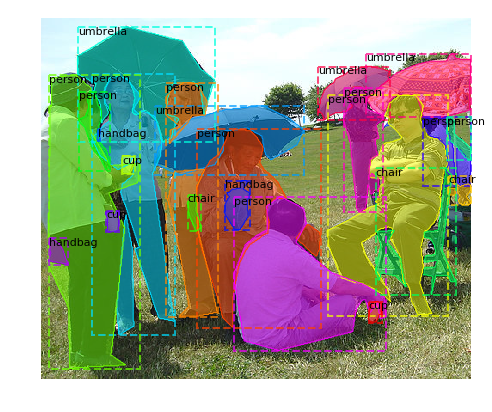

In [10]:
## 62642 (persons),   68539 (trucks) 36466 (surfers)  75040 (boat and persons)
## 36466 surfers. 5498 basketbal players, 27711,30531
## 5498 lots of motorcylces & persons - 
## Persons: #26026, #7719, 111864, 58240,  
## 89243: Person, bicylce and traiffic lights
## 35347 - laptops, keyboards and cat
## items = [59199 , 102868]
## 101623 (cake and forks), 41423 (elephant & people)
from mrcnn.datagen_fcn  import fcn_data_gen_simulate
# train_batch_x, train_batch_y = next(train_generator)
train_batch_x, train_batch_y , train_images =  fcn_data_gen_simulate(dataset_train, fcn_config, [40, 243])
for i in train_batch_x:
    print(i.shape)
print(train_images.shape)
print(fcn_model.keras_model.input_names)
imgmeta_idx = fcn_model.keras_model.input_names.index('input_image_meta')
print(imgmeta_idx)

img_meta    = train_batch_x[imgmeta_idx]
print(img_meta)



for img_idx in range(2):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print('Image meta  : ', img_meta[img_idx,:10])
    print('Classes     : ', class_ids)
    print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
    print(' class_ids.shape[0]:', class_ids.shape[0], 'bbox.shape[0]:',bbox.shape[0]) 
    unmolded_image = utils.unmold_image(train_images[img_idx], fcn_config)
    visualize.display_image(unmolded_image)
    resized_image =  utils.unresize_image(unmolded_image, img_meta[img_idx])
    visualize.display_image(resized_image)
    visualize.display_image(train_batch_x[1][img_idx,:,:,1], title= 'heatmap')
    visualize.display_image(np.fliplr(train_batch_x[1][img_idx,:,:,1]), title= 'flipped heatmap')
    class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
    print('Class Names : ', class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)   
    # Display image and instances
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))    

In [ ]:
print(dataset_train.image_info[243]['id'])
print(dataset_train.image_info[243]['path'])
# dataset_train.image_ids[:100]

# image_id = img_meta[img_idx,0]
# image = dataset_train.load_image(image_id)
# mask, class_ids = dataset_train.load_mask(image_id)
# bbox = utils.extract_bboxes(mask)
# print('Image meta  : ', img_meta[img_idx,:10])
# print('Classes     : ', class_ids)
# print("image_id    : ", image_id, ' Reference: ', dataset_train.image_reference(image_id))
# print(' class_ids.shape[0]:', class_ids.shape[0], 'bbox.shape[0]:',bbox.shape[0]) 
# unmolded_image = utils.unmold_image(train_images[img_idx], fcn_config)
# visualize.display_image(unmolded_image)
# resized_image =  utils.unresize_image(unmolded_image, img_meta[img_idx])
# visualize.display_image(resized_image)
# visualize.display_image(train_batch_x[1][0,:,:,1])
# class_names = [str(dataset_train.class_names[class_id]) for class_id in class_ids]
# print('Class Names : ', class_names)
# visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)   
# # Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))    

In [ ]:
from mrcnn.visualize import display_heatmaps, display_heatmaps_fcn, display_heatmaps_mrcnn
# visualize.display_image_bw(image)
# class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
display_heatmaps(train_batch_x, train_images, 0, hm = 'pr', config = fcn_config, class_ids = [0,1,2,3,4,5,24], class_names = dataset_train.class_names)
# display_heatmaps(train_batch_x, 0, hm = 'gt', config = mrcnn_config, class_ids = [0,1,2,3,4,5,24],

##  Plot heatmaps returned from heatmap generator over images


### Display images overlaid by heatmaps 

In [11]:
from mrcnn.visualize import  plot_3d_heatmap, plot_2d_heatmap, display_heatmaps_fcn
import matplotlib as plt

%matplotlib inline
print('Image id: ',image_id)
img_id = 1
class_names = dataset_train.class_names

Image id:  243


pr_class ids:  [0, 1, 40, 55, 56, 61]
gt_class ids:  [0, 1, 40, 56, 61]
 class_ids: [0, 1, 40, 55, 56, 61]
1- Image    :  (1024, 1024, 3) float32 -123.7 151.1
2- image    :  (1024, 1024, 3) uint8 0 255


/users/students/r0653928/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/users/students/r0653928/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


3- image    :  (536, 640, 3) uint8 1 255
4- image_bw:  (536, 640) uint8 5 254


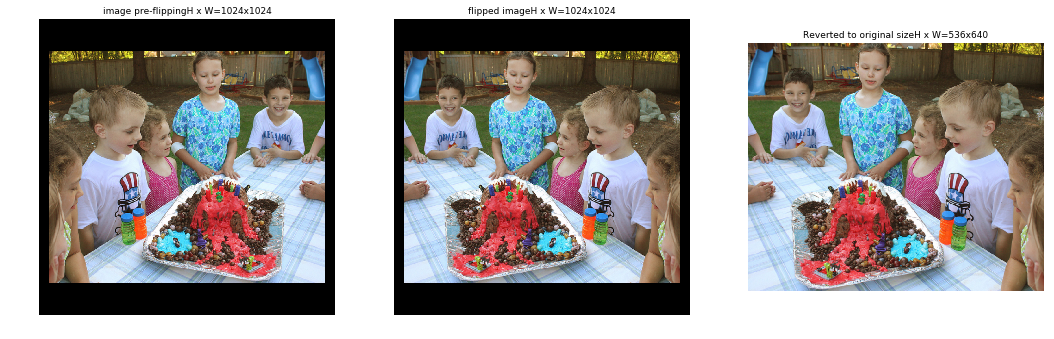

 boxes_to_image_domain() 
    Original image shape : [536 640   3]   Image window info: [112  34 912 989] 
    Adjustment scale     : [0.67 0.67 0.67 0.67]   Adjustment shift : [112  34] 
    Adjusted boxes shape : (81, 200, 4) 


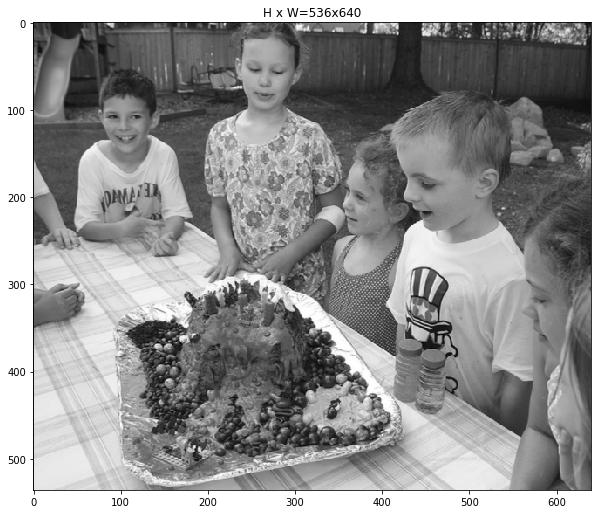

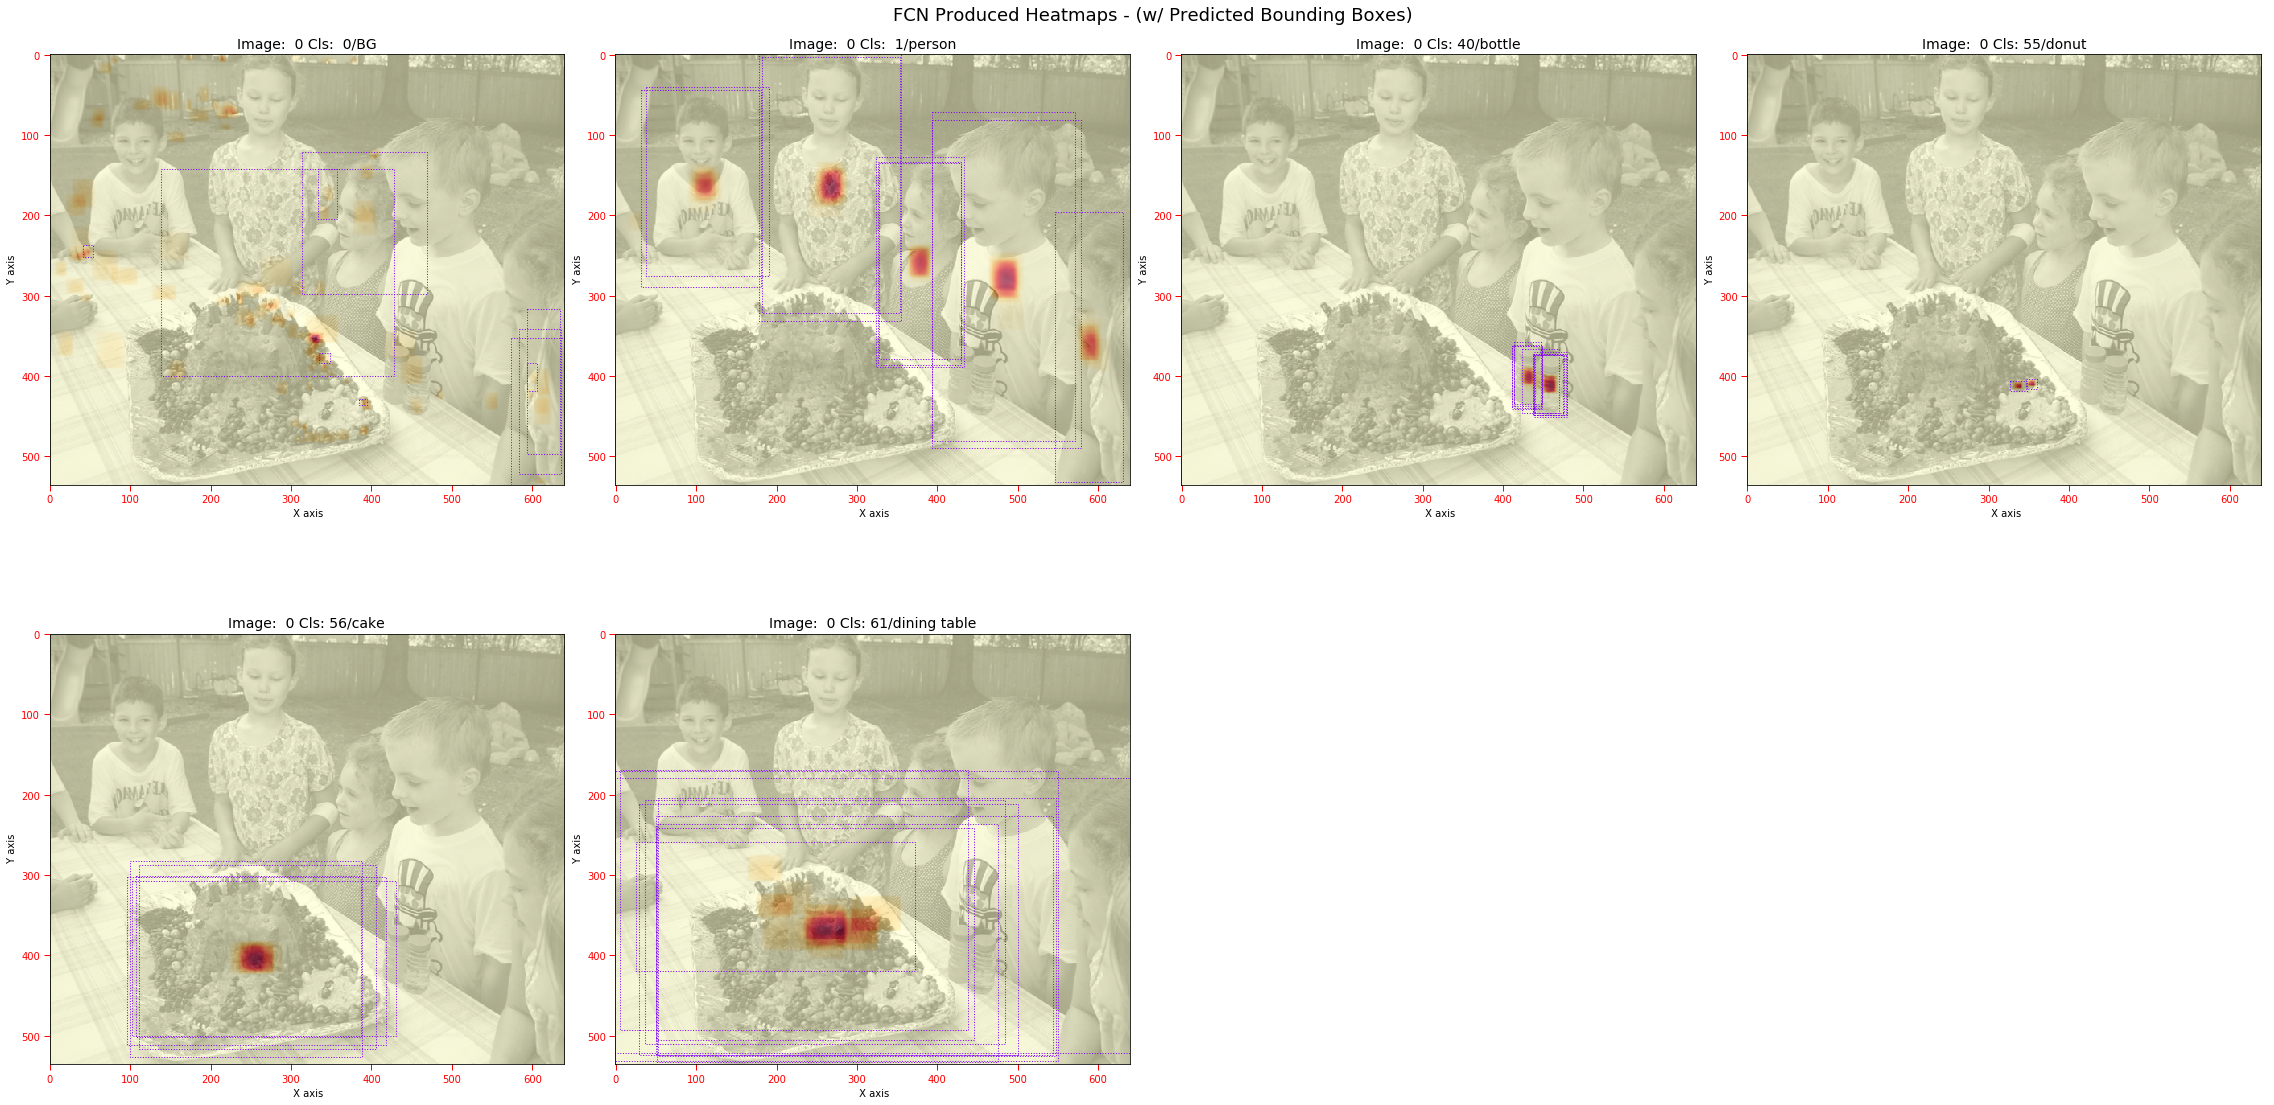

In [45]:
img_id = 0
pr_class_ids = np.unique(train_batch_x[2][img_id,:,:,4]).astype(int).tolist()
gt_class_ids = np.unique(train_batch_x[4][img_id,:,:,4]).astype(int).tolist()
print('pr_class ids: ', pr_class_ids)
print('gt_class ids: ', gt_class_ids)
visualize.display_heatmaps_fcn(train_batch_x, train_images, img_id, hm='pr',class_ids = pr_class_ids, flip = True,
                               class_names = class_names, num_bboxes = 10, columns = 4, config = fcn_config)

pr_class ids:  [0, 1, 26, 42, 57, 66, 68]
gt_class ids:  [0, 1, 26, 27, 42, 57]
 class_ids: [0, 1, 26, 42, 57, 66, 68]
1- Image    :  (1024, 1024, 3) float32 -123.7 151.1
2- image    :  (1024, 1024, 3) uint8 0 255
3- image    :  (420, 500, 3) uint8 0 255
4- image_bw:  (420, 500) uint8 2 254


/users/students/r0653928/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/users/students/r0653928/anaconda3/envs/TFG/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


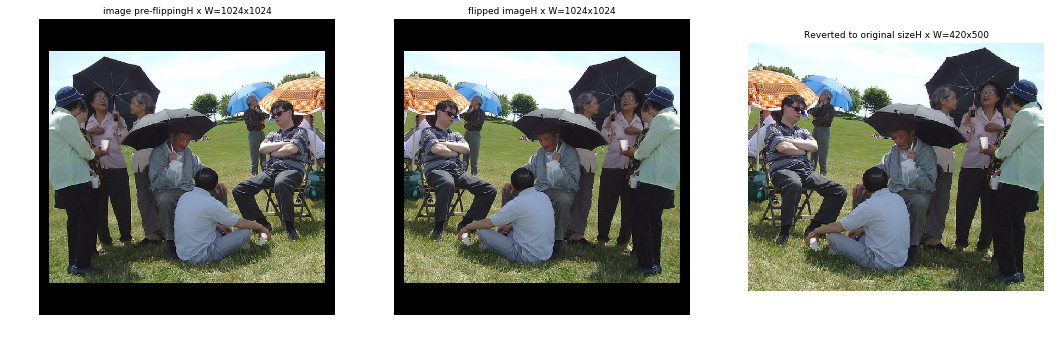

 boxes_to_image_domain() 
    Original image shape : [420 500   3]   Image window info: [112  36 912 988] 
    Adjustment scale     : [0.525 0.525 0.525 0.525]   Adjustment shift : [112  36] 
    Adjusted boxes shape : (81, 200, 4) 


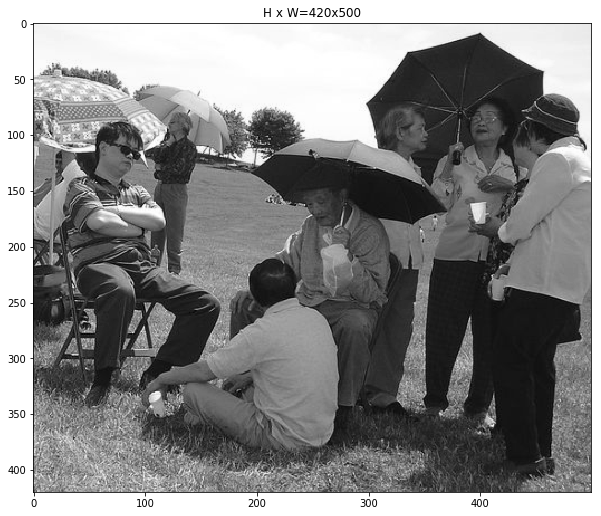

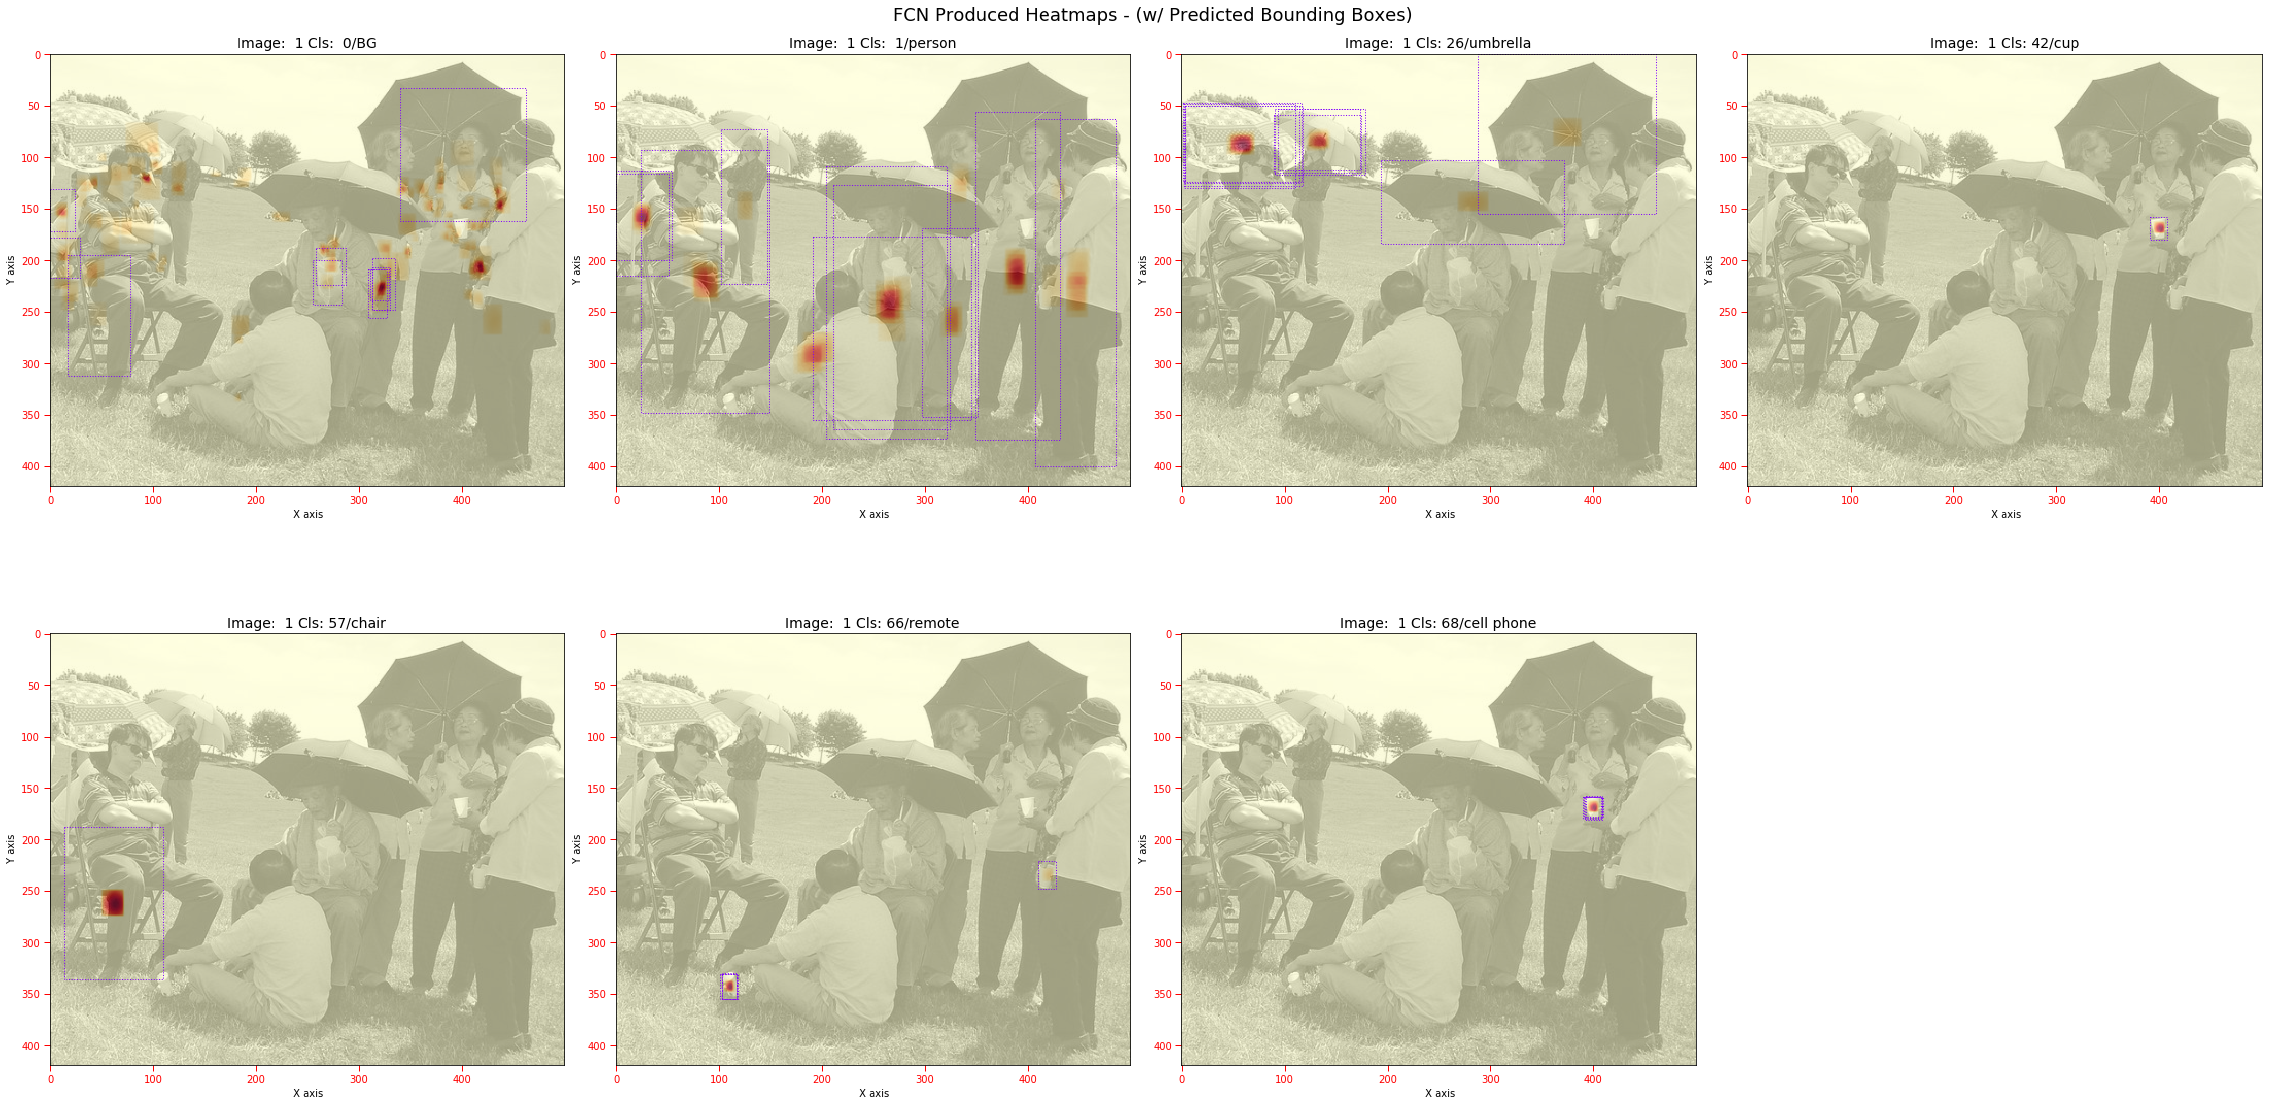

In [44]:
img_id = 1
pr_class_ids = np.unique(train_batch_x[2][img_id,:,:,4]).astype(int).tolist()
gt_class_ids = np.unique(train_batch_x[4][img_id,:,:,4]).astype(int).tolist()
print('pr_class ids: ', pr_class_ids)
print('gt_class ids: ', gt_class_ids)
visualize.display_heatmaps_fcn(train_batch_x, train_images, img_id, hm='pr',class_ids = pr_class_ids, flip = True,
                               class_names = class_names, num_bboxes = 10, columns = 4, config = fcn_config)

In [ ]:
from mrcnn.visualize import plot_2d_gaussian
print(train_batch_x[1][0,:,:,1].shape)
plot_2d_gaussian(train_batch_x[1][1,:,:,1])

### other image displays

####  Display Training / Validation Training set information

In [ ]:
print("Train Dataset Image Count: {}".format(len(dataset_train.image_ids)))
print("Training Dataset Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
    
print("Validation Dataset Image Count: {}".format(len(dataset_val.image_ids)))
print("Validation Dataset Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))    

#### Display top masks for a random group of images

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 7)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Display a random image with instances and mask

In [ ]:
# Load random image and mask.
# image_id = np.random.choice(dataset_train.image_ids)


image    = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)

##  Load Model Weights

In [ ]:
# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
mrcnn_model.load_model_weights(init_with = 'last', exclude = None)  

In [ ]:
##------------------------------------------------------------------------------------
## Load FCN Model weights  
##------------------------------------------------------------------------------------
fcn_model.load_model_weights(init_with = 'last') # 'fcn_config.VGG16_MODEL_PATH')

## FCN `train_in_batches()`

In [ ]:
print('--- MRCNN-------------------------------------------------------')
log("Epochs to run       {} ".format(mrcnn_model.config.EPOCHS_TO_RUN))
log("Steps per epochs    {} ".format(mrcnn_model.config.STEPS_PER_EPOCH))
log("Batch size          {} ".format(mrcnn_model.config.BATCH_SIZE))
log("Learning Rate       {} ".format(mrcnn_model.config.LEARNING_RATE))
log("Momentum            {} ".format(mrcnn_model.config.LEARNING_MOMENTUM))
log("Weight Decay:       {} ".format(mrcnn_model.config.WEIGHT_DECAY       ))
log("VALIDATION_STEPS    {} ".format(mrcnn_model.config.VALIDATION_STEPS   ))
# log("Checkpoint Path:    {} ".format(mrcnn_model.checkpoint_path))
# log("REDUCE_LR_FACTOR    {} ".format(mrcnn_model.config.REDUCE_LR_FACTOR   ))
# log("REDUCE_LR_COOLDOWN  {} ".format(mrcnn_model.config.REDUCE_LR_COOLDOWN ))
# log("REDUCE_LR_PATIENCE  {} ".format(mrcnn_model.config.REDUCE_LR_PATIENCE ))
# log("MIN_LR              {} ".format(mrcnn_model.config.MIN_LR             ))
# log("EARLY_STOP_PATIENCE {} ".format(mrcnn_model.config.EARLY_STOP_PATIENCE))     

fcn_config.EPOCHS_TO_RUN  = 4
fcn_config.LEARNING_RATE  = 0.1

print('--- FCN --------------------------------------------------------')
log("Epochs to run       {} ".format(fcn_model.config.EPOCHS_TO_RUN))
log("Steps per epochs    {} ".format(fcn_model.config.STEPS_PER_EPOCH))
log("Batch size          {} ".format(fcn_model.config.BATCH_SIZE))
log("Learning Rate       {} ".format(fcn_model.config.LEARNING_RATE))
log("Momentum            {} ".format(fcn_model.config.LEARNING_MOMENTUM))
log("Weight Decay:       {} ".format(fcn_model.config.WEIGHT_DECAY       ))
log("VALIDATION_STEPS    {} ".format(fcn_model.config.VALIDATION_STEPS   ))
log("Checkpoint Path:    {} ".format(fcn_model.checkpoint_path))
log("REDUCE_LR_FACTOR    {} ".format(fcn_model.config.REDUCE_LR_FACTOR   ))
log("REDUCE_LR_COOLDOWN  {} ".format(fcn_model.config.REDUCE_LR_COOLDOWN ))
log("REDUCE_LR_PATIENCE  {} ".format(fcn_model.config.REDUCE_LR_PATIENCE ))
log("MIN_LR              {} ".format(fcn_model.config.MIN_LR             ))
log("EARLY_STOP_PATIENCE {} ".format(fcn_model.config.EARLY_STOP_PATIENCE))    

In [ ]:
##----------------------------------------------------------------------------------------------
## Train the FCN only 
## Passing layers="heads" freezes all layers except the head
## layers. You can also pass a regular expression to select
## which layers to train by name pattern.
##----------------------------------------------------------------------------------------------            
train_layers = ['fcn']
loss_names   = ["fcn_heatmap_loss"]
fcn_config.LAST_EPOCH_RAN = 56
fcn_model.epoch = fcn_config.LAST_EPOCH_RAN

fcn_model.train_in_batches(
            mrcnn_model,    
            dataset_train,
            dataset_val, 
            layers = train_layers,
            losses = loss_names
            )


In [ ]:
#### Simulate Train in Batches

## Run data through MRCNN and FCN models

####  Display model input / output information

In [ ]:
mrcnn_model.layer_info()
print('\n FCN')
fcn_model.layer_info()

In [ ]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
# model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [4,5,6,7,9,10,11,12,13,14], 1)
# model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3,4,5,6,7,9,10,11], 1)
model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3,4,5], 1)


### Load input and output tensors

In [ ]:
print(len(model_output))

# output_rois               = model_output[0]          # layer:  4   shape: (1, 200, 4)
# target_class_ids          = model_output[1]          # layer:  5   shape: (1, 200)
# target_bbox_deltas        = model_output[2]          # layer:  6   shape: (1, 200, 4)
# roi_gt_boxes              = model_output[3]          # layer:  7   shape: (1, 200, 4)
# mrcnn_class               = model_output[4]          # layer:  8   shape: (1, 200, 81)
# mrcnn_bbox                = model_output[5]          # layer:  9   shape: (1, 200, 81, 4)
# pred_refined_tensor       = model_output[6]          # layer: 16   shape: (1, 81, 25, 7)
# output_rois               = model_output[0]          # layer:  0   shape: (2, 200, 4)
# target_class_ids          = model_output[1]          # layer:  1   shape: (2, 200)
# target_bbox_deltas        = model_output[2]          # layer:  2   shape: (2, 200, 4)
# roi_gt_boxes              = model_output[3]          # layer:  3   shape: (2, 200, 4)
# mrcnn_class               = model_output[4]          # layer:  4   shape: (2, 200, 81)
# mrcnn_bbox                = model_output[5]          # layer:  5   shape: (2, 200, 81, 4)
# model_pred_heatmap_norm         = model_output[6]          # layer:  6   shape: (2, 256, 256, 81)
# model_pred_heatmap_scores       = model_output[7]          # layer:  7   shape: (2, 81, 25, 11)
# model_gt_heatmap_scores         = model_output[8]          # layer:  9   shape: (2, 81, 25, 11)
# model_pred_tensor               = model_output[9]          # layer: 10   shape: (2, 81, 25, 8)
# model_gt_tensor                 = model_output[10]          # layer: 11   shape: (2, 81, 25, 8)

pred_heatmap_norm         = model_output[0]          # layer:  0   shape: (2, 256, 256, 81)
pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (2, 81, 200, 11)
gt_heatmap_norm           = model_output[2]          # layer:  2   shape: (2, 256, 256, 81)
gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (2, 81, 200, 11)
pred_tensor               = model_output[4]          # layer:  4   shape: (2, 81, 200, 8)
gt_tensor                 = model_output[5]          # layer:  5   shape: (2, 81, 200, 8)
for i in model_output:
    print( i.shape)

In [ ]:
# fcn_input = [pred_heatmap_norm, pred_heatmap_scores, gt_heatmap_norm, gt_heatmap_scores] 
model_output2 = get_layer_output_1(fcn_model.keras_model, fcn_input, [0,1], 1)

### Load input data

In [ ]:
input_image          =  train_batch_x[0]
input_image_meta     =  train_batch_x[1]
# input_rpn_match      =  train_batch_x[2]
# input_rpn_bbox       =  train_batch_x[3]
input_gt_class_ids   =  train_batch_x[4]
input_gt_bboxes      =  train_batch_x[5]
print(' Input image shape is    :', input_image.shape)
print(' input_image_meta        :', input_image_meta[0,:10])
# print(' input_rpn_match         :', input_rpn_match.shape)
# print(' input_rpn_bbox          :', input_rpn_bbox.shape)
print(' input_gt_class_ids      :', input_gt_class_ids.shape)
print(' input_gt_bboxes         :', input_gt_bboxes.shape)
# h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
# input_gt_bboxes_norm = tf.identity(input_gt_bboxes / [h,w,h,w])
# print(' input_gt_bboxes_norm    :', input_gt_bboxes_norm.shape)

##  Plot heatmaps


### Plot 2D heatmap of  one `pred_heatmap` distribution generated in `build_heatmap`

In [ ]:
from mrcnn.visualize import plot_one_bbox_heatmap, plot_3d_heatmap, plot_3d_heatmap_all_classes, plot_2d_heatmap, plot_2d_heatmap_with_bboxes
import matplotlib as plt

%matplotlib notebook
print('Image id: ',image_id)
img_id = 0
class_names = dataset_train.class_names

####  2D plot of `pred_heatmap_norm` returned from model : `model_pred_heatmap_norm`

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(pred_heatmap_norm.shape)
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    
#     plot_2d_heatmap_with_bboxes(model_pred_heatmap_norm, model_pred_heatmap_scores, 
#                                 img_id, [0], width=6, height=6, class_names = class_names, scale = 4)
#     plot_2d_heatmap_with_bboxes( pred_heatmap_norm,  pred_heatmap_scores, 
#                                 img_id, [0], width=6, height=6, class_names = class_names, scale = 4)    
    
#     plot_2d_heatmap(pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


####  2D plot of `pred_heatmap_norm` returned from model

In [ ]:
for img_id in [1]:     ##range(mrcnn_config.BATCH_SIZE):
    print(pred_heatmap_norm.shape)
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_with_bboxes( pred_heatmap_norm,  pred_heatmap_scores, 
                                img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)      
#     plot_2d_heatmap(model_pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


####  2D plot of `gt_heatmap_norm` returned from model

In [ ]:
for img_id in [1]:     ##range(mrcnn_config.BATCH_SIZE):
    print(gt_heatmap_norm.shape)
    class_ids = np.unique(gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_with_bboxes(gt_heatmap_norm, gt_heatmap_scores, 
                                img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

####  3D plot of `model_pred_heatmap_norm` returned form model

In [ ]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, [37], width=6, height=6, class_names = class_names)


####  3D plot of  `pred_heatmap_norm` returned form code above

In [ ]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(pred_heatmap_norm.shape)
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


####  3D plot of  `gt_heatmap_norm` returned form code above

In [ ]:
for img_id in [1]: ## range(mrcnn_config.BATCH_SIZE):
    print(gt_heatmap_norm.shape)
    class_ids = np.unique(gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(gt_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


#### Verfiy max and min of gaussian heatmaps are 1.0 and 0.0, respectively 

In [ ]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
print(pred_heatmap_norm.shape)
hm_max = np.max(pred_heatmap_norm, axis = (1,2))
hm_min = np.min(pred_heatmap_norm, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])

print(gt_heatmap_norm.shape)
hm_max = np.max(gt_heatmap_norm, axis = (1,2))
hm_min = np.min(gt_heatmap_norm, axis = (1,2))
print(hm_max.shape)
for img_id in range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    class_ids = np.unique(gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('\n Image : {}  ClassIds: {}'.format(img_id, class_ids))
    print('-'*38)
    for cls in class_ids: 
        print(' class: {}   max: {}  min: {}'.format(cls, hm_max[img_id,cls], hm_min[img_id,cls]))
#         print(pred_heatmap_scores[img_id, cls])
        
     

###  Display `pred_scatter` heatmaps for all bounding boxes of an image

In [ ]:
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,0,0])
plot_bbox_heatmaps(gauss_scatt[img], pred_tensor[img], width = 15, height=25, num_bboxes=12)

###  Display `gauss_heatmap` heatmap (not normalized, normlized, L2 normalized)

In [ ]:

%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
print(pred_heatmap_scores[img,0,0])
# plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='Non-normalized')
plot_gaussian(pred_heatmap_norm[img,:,:,1],0, 
plot_one_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='normalized')
# plot_one_heatmap(pred_heatmap_L2norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='L2-normalized')
# plot_heatmaps(pred_heatmap, pred_heatmap_scores, width = 15, num_bboxes=12)

###  Display `gauss_heatmap` 3D heatmap (not normalized, normlized, L2 normalized)

In [ ]:
from mrcnn.visualize import plot_3d_heatmap
%matplotlib notebook
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 1
print(pred_heatmap_scores[img,cls,:10])

ttl = 'Non-normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)

ttl = 'Normalized - image: {}'.format(img)
plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
plot_one_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)
